<a href="https://colab.research.google.com/github/AlirezaSamari/DeepLearning-Pytorch-fastai-and/blob/main/06_Image_segmentation_with_CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastcore import*

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
path.ls()

(#4) [Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/labels'),Path('/root/.fastai/data/camvid/images')]

In [4]:
(path/'labels').ls()

(#701) [Path('/root/.fastai/data/camvid/labels/0001TP_006840_P.png'),Path('/root/.fastai/data/camvid/labels/Seq05VD_f04470_P.png'),Path('/root/.fastai/data/camvid/labels/0006R0_f01740_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_01470_P.png'),Path('/root/.fastai/data/camvid/labels/Seq05VD_f02010_P.png'),Path('/root/.fastai/data/camvid/labels/0006R0_f01140_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_07860_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_01650_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_08111_P.png'),Path('/root/.fastai/data/camvid/labels/Seq05VD_f05010_P.png')...]

## Data

In [5]:
valid_fnames = (path/'valid.txt').read_text().split('\n')
valid_fnames[0:5]


['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [6]:
path_img = path/'images'
path_lbl = path/'labels'

In [7]:
fnames    = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

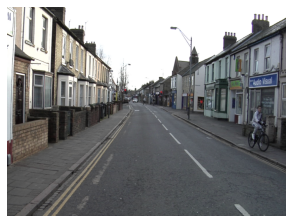

In [8]:
img_f = fnames[10]
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [9]:
get_msk = lambda x: path/'labels'/f'{x.stem}_P{x.suffix}'

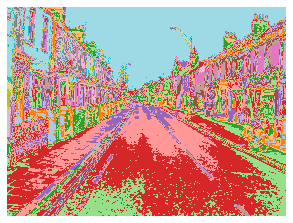

In [10]:
msk = PILMask.create(img_f)
msk.show(figsize=(5,5), alpha = 1)

In [11]:
tensor(msk)

tensor([[255, 255, 247,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [254, 255, 255,  ..., 255, 255, 255],
        ...,
        [ 67,  65,  65,  ...,  67,  69,  75],
        [ 73,  71,  73,  ...,  67,  72,  79],
        [ 77,  74,  79,  ...,  75,  73,  71]], dtype=torch.uint8)

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype = str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
def FileSplitter(fname):
  valid = Path(fname).read_text().split('\n')
  def func(x) : return x.name in valid
  def inner(o) : return FuncSplitter(func)(o)
  return inner

In [14]:
sz = msk.shape; sz

(720, 960)

In [15]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [16]:
camvid = DataBlock(blocks=[ImageBlock, MaskBlock(codes)], get_items = get_image_files,
                   splitter = FileSplitter(path/'valid.txt'), get_y = get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [17]:
dls = camvid.dataloaders(path/'images', bs=8)

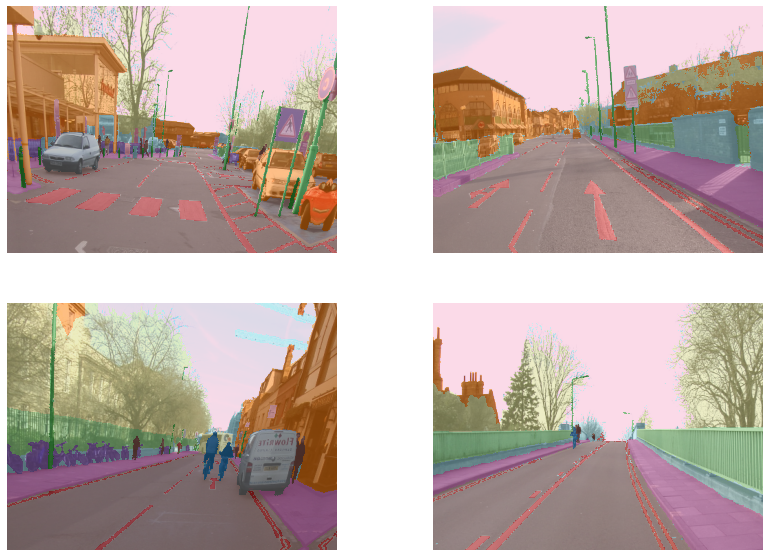

In [18]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [19]:
dls.vocab = codes

In [20]:
name2id = {v:k for k,v in enumerate(codes)}; name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [21]:
void_code = name2id['Void']
void_code

30

In [22]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [23]:
opt = ranger

In [24]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.00013182566908653826)

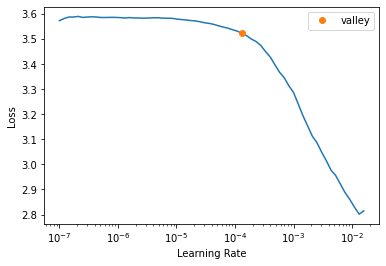

In [25]:
learn.lr_find()

In [26]:
lr = 1e-3

In [27]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.090560,0.968368,0.785421,01:37
1,1.035271,0.697121,0.819861,01:37
2,0.712221,0.520464,0.849740,01:36
3,0.575106,0.385547,0.882479,01:37
4,0.484815,0.420794,0.873871,01:36
5,0.422663,0.324740,0.903583,01:37
6,0.368929,0.316080,0.906642,01:37
7,0.331635,0.289509,0.920166,01:37
8,0.302508,0.285730,0.920415,01:37
9,0.286775,0.289338,0.917829,01:36


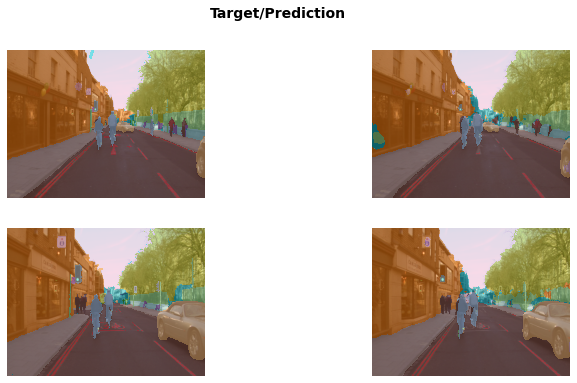

In [29]:
learn.show_results(max_n=2, figsize=(12, 6))